In [1]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools

# 1. A Recurrent Representation of SNNs
$$U[t+1] = \underbrace{\beta U[t]}_\text{decay} + \underbrace{WX[t+1]}_\text{input} - \underbrace{R[t]}_\text{reset} \tag{1}$$
$$S[t] = \begin{cases} 1, &\text{if}~U[t] > U_{\rm thr} \\
0, &\text{otherwise}\end{cases} \tag{2}$$
$$S[t] = \Theta(U[t] - U_{\rm thr}) \tag{3}$$
$$\frac{\partial \mathcal{L}}{\partial W} = 
\frac{\partial \mathcal{L}}{\partial S}
\underbrace{\frac{\partial S}{\partial U}}_{\{0, \infty\}}
\frac{\partial U}{\partial I}\
\frac{\partial I}{\partial W}\ \tag{4}$$
$$ \frac{\partial \tilde{S}}{\partial U} \leftarrow \frac{1}{\pi}\frac{1}{(1+[U\pi]^2)} \tag{5}$$
$$\frac{\partial \mathcal{L}}{\partial W}=\sum_t \frac{\partial\mathcal{L}[t]}{\partial W} = 
\sum_t \sum_{s\leq t} \frac{\partial\mathcal{L}[t]}{\partial W[s]}\frac{\partial W[s]}{\partial W} \tag{5} $$
$$\frac{\partial \mathcal{L}}{\partial W}=
\sum_t \sum_{s\leq t} \frac{\partial\mathcal{L}[t]}{\partial W[s]} \tag{6} $$
$$\frac{\partial \mathcal{L}[t]}{\partial W[t-1]} = 
\frac{\partial \mathcal{L}[t]}{\partial S[t]}
\underbrace{\frac{\partial \tilde{S}[t]}{\partial U[t]}}_{Eq.~(5)}
\underbrace{\frac{\partial U[t]}{\partial U[t-1]}}_\beta
\underbrace{\frac{\partial U[t-1]}{\partial I[t-1]}}_1
\underbrace{\frac{\partial I[t-1]}{\partial W[t-1]}}_{X[t-1]} \tag{7}$$
$$p_i[t] = \frac{e^{U_i[t]}}{\sum_{j=0}^{C}e^{U_j[t]}} \tag{8}$$
$$\mathcal{L}_{CE}[t] = -\sum_{i=0}^Cy_i{\rm log}(p_i[t]) \tag{9}$$
$$\mathcal{L}_{CE} = \sum_t\mathcal{L}_{CE}[t] \tag{10}$$


In [2]:
batch_size = 128
data_path='E:/Code/SCNN-and-Resnet50-on-Medical-MNIST-classification/data/raw'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_dataset = datasets.ImageFolder(data_path, transform=transform)

train_size = int(0.8 * len(mnist_dataset))  # 80% for training
test_size = len(mnist_dataset) - train_size  # 20% for testing

mnist_train, mnist_test = random_split(mnist_dataset, [train_size, test_size])

print(len(mnist_train))
print(len(mnist_test))

print(mnist_dataset.class_to_idx)

47163
11791
{'AbdomenCT': 0, 'BreastMRI': 1, 'CXR': 2, 'ChestCT': 3, 'Hand': 4, 'HeadCT': 5}


In [4]:
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [5]:
# Network Architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 6

# Temporal Dynamics
num_steps = 25
beta = 0.95

In [6]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
        
# Load the network onto CUDA if available
net = Net().to(device)

In [7]:
# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer(
    data, targets, epoch,
    counter, iter_counter,
        loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [8]:
loss = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

In [9]:
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

In [10]:
spk_rec, mem_rec = net(data.view(batch_size, -1))
print(mem_rec.size())

torch.Size([25, 128, 6])


In [11]:
# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")

Training loss: 45.763


In [12]:
print_batch_accuracy(data, targets, train=True)

Train set accuracy for a single minibatch: 17.19%


In [13]:
# clear previously stored gradients
optimizer.zero_grad()

# calculate the gradients
loss_val.backward()

# weight update
optimizer.step()

In [14]:
# calculate new network outputs using the same data
spk_rec, mem_rec = net(data.view(batch_size, -1))

# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")
print_batch_accuracy(data, targets, train=True)

Training loss: 38.007
Train set accuracy for a single minibatch: 28.91%


In [15]:
net.to(device)
#check device
print(next(net.parameters()).is_cuda)

num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer(
                    data, targets, epoch, counter, iter_counter,
                    loss_hist, test_loss_hist, test_data, test_targets
                )
            counter += 1
            iter_counter +=1

True


Epoch 0, Iteration 0
Train Set Loss: 41.46
Test Set Loss: 33.37
Train set accuracy for a single minibatch: 53.12%
Test set accuracy for a single minibatch: 53.12%


Epoch 0, Iteration 50
Train Set Loss: 8.49
Test Set Loss: 5.77
Train set accuracy for a single minibatch: 95.31%
Test set accuracy for a single minibatch: 96.09%


Epoch 0, Iteration 100
Train Set Loss: 5.07
Test Set Loss: 6.31
Train set accuracy for a single minibatch: 92.97%
Test set accuracy for a single minibatch: 96.88%


Epoch 0, Iteration 150
Train Set Loss: 3.30
Test Set Loss: 4.07
Train set accuracy for a single minibatch: 88.28%
Test set accuracy for a single minibatch: 88.28%


Epoch 0, Iteration 200
Train Set Loss: 9.71
Test Set Loss: 3.07
Train set accuracy for a single minibatch: 78.12%
Test set accuracy for a single minibatch: 77.34%


Epoch 0, Iteration 250
Train Set Loss: 2.02
Test Set Loss: 2.77
Train set accuracy for a single minibatch: 92.19%
Test set accuracy for a single minibatch: 94.53%


Epoch 0, It

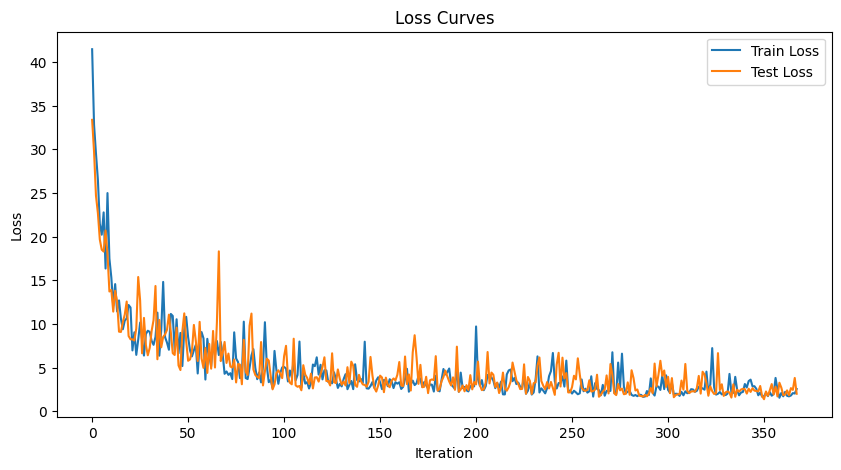

In [16]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [17]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)

    # forward pass
    test_spk, _ = net(data.view(data.size(0), -1))

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

In [18]:
print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 11460/11791
Test Set Accuracy: 97.19%
